In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import os

In [2]:
def run_command(cmd):
    print(f"Running command: {cmd}")
    os.system(cmd)

In [3]:
# Read in peaks
peaks_threeMB_all = pd.read_table("Input/3MB.mRp.clN_peaks.bed", sep="\t", header=0)
peaks_dmso_all = pd.read_table("Input/DMSO.mRp.clN_peaks.bed", sep="\t", header=0)
peaks_consensus = pd.read_table(
    "Input/consensus_peaks.mRp.clN.boolean.txt", sep="\t", header=0
)
down_in_3MB_peaks_sig = pd.read_csv(
    "Output/differential_peaks_down_in_3MB.bed", sep="\t"
)
up_in_3MB_peaks_sig = pd.read_csv("Output/differential_peaks_up_in_3MB.bed", sep="\t")

differential_peaks = pd.concat([down_in_3MB_peaks_sig, up_in_3MB_peaks_sig])

# Basic peak stats

In [41]:
print(f"Number of DMSO peaks: {len(peaks_dmso_all)}")
print(f"Number of 3MB peaks: {len(peaks_threeMB_all)}")
print(f"Number of merged peaks: {len(peaks_consensus)}")

num_unique_DMSO = len(peaks_consensus[peaks_consensus["DMSO.mRp.clN.bool"] & ~peaks_consensus["3MB.mRp.clN.bool"]])
print(f"Number of merged peaks unique to DMSO: {num_unique_DMSO}")
num_unique_3MB = len(peaks_consensus[peaks_consensus["3MB.mRp.clN.bool"] & ~peaks_consensus["DMSO.mRp.clN.bool"]])
print(f"Number of merged peaks unique to 3MB: {num_unique_3MB}")
num_shared = len(peaks_consensus[peaks_consensus["DMSO.mRp.clN.bool"] & peaks_consensus["3MB.mRp.clN.bool"]])
print(f"Number of merged peaks shared: {num_shared}")

print(f"Number of merged peaks differentially down in 3MB: {len(down_in_3MB_peaks_sig)}")
print(f"Number of merged peaks differentially up in 3MB: {len(up_in_3MB_peaks_sig)}")

Number of DMSO peaks: 386615
Number of 3MB peaks: 488816
Number of merged peaks: 551262
Number of merged peaks unique to DMSO: 88640
Number of merged peaks unique to 3MB: 169751
Number of merged peaks shared: 292871
Number of merged peaks differentially down in 3MB: 11569
Number of merged peaks differentially up in 3MB: 59


# Plotting peak overlap
Peak overlaps: out of the consensus peaks (combined peaks between DMSO and 3MB), how many were unique to DMSO and 3MB?

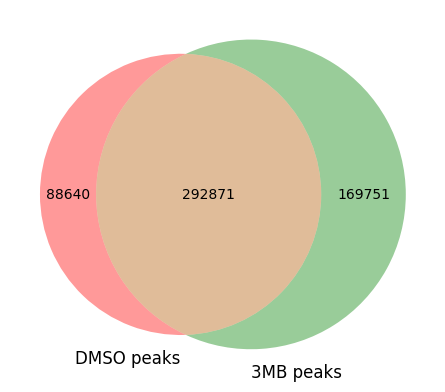

In [42]:
venn2(subsets=(num_unique_DMSO, num_unique_3MB, num_shared), set_labels=('DMSO peaks', '3MB peaks'))
plt.show()

# Plotting peak types (static vs differential)

Plots the number of peaks that are static and differential, considering the peaks from DMSO and the peaks from the 3MB treatment separately.

Assumes that `homer-analysis.Rmd` has already been run.

## Create bar plot for types of regions

Considers the regions originally from DMSO and the regions originally from 3MB separately.
For each region, identifies it as static, up in 3MB, or down in 3MB.

In [13]:
# Add labels for each region
peaks_consensus["consensus_fullname"] = (
    peaks_consensus["chr"]
    + ":"
    + peaks_consensus["start"].astype(str)
    + "-"
    + peaks_consensus["end"].astype(str)
)
differential_peaks["consensus_fullname"] = (
    differential_peaks["chr"]
    + ":"
    + differential_peaks["start"].astype(str)
    + "-"
    + differential_peaks["end"].astype(str)
)
peaks_dmso_all = peaks_dmso_all[["chr", "start", "end"]]
peaks_dmso_all["peak_fullname"] = (
    peaks_dmso_all["chr"] + ":"
    + (peaks_dmso_all["start"] - 1).astype(str)
    + "-" + peaks_dmso_all["end"].astype(str)
)
peaks_threeMB_all = peaks_threeMB_all[["chr", "start", "end"]]
peaks_threeMB_all["peak_fullname"] = (
    peaks_threeMB_all["chr"] + ":"
    + (peaks_threeMB_all["start"] - 1).astype(str)
    + "-" + peaks_threeMB_all["end"].astype(str)
)
peaks_consensus.loc[peaks_consensus["DMSO.mRp.clN.bool"], "from_dmso_peak"] = (
    peaks_consensus["chr"]
    + ":" + peaks_consensus["DMSO.mRp.clN.start"].astype(str)
    + "-" + peaks_consensus["DMSO.mRp.clN.end"].astype(str)
)
peaks_consensus.loc[peaks_consensus["3MB.mRp.clN.bool"], "from_3MB_peak"] = (
    peaks_consensus["chr"]
    + ":"
    + peaks_consensus["3MB.mRp.clN.start"].astype(str)
    + "-"
    + peaks_consensus["3MB.mRp.clN.end"].astype(str)
)

# Add in annotation for consensus and differential peaks
peaks_dmso_all = peaks_dmso_all.merge(
    peaks_consensus[["consensus_fullname", "from_dmso_peak", "from_3MB_peak"]], left_on="peak_fullname", right_on="from_dmso_peak", how="left"
)
peaks_dmso_all = peaks_dmso_all.merge(
    differential_peaks[["consensus_fullname", "log2FoldChange"]], on="consensus_fullname", how="left"
)
peaks_threeMB_all = peaks_threeMB_all.merge(
    peaks_consensus[["consensus_fullname", "from_dmso_peak", "from_3MB_peak"]], left_on="peak_fullname", right_on="from_3MB_peak", how="left"
)
peaks_threeMB_all = peaks_threeMB_all.merge(
    differential_peaks[["consensus_fullname", "log2FoldChange"]], on="consensus_fullname", how="left"
)

# Define each region as either static, differential_up or differential_down
peaks_dmso_all["region_type"] = "static"
peaks_dmso_all.loc[peaks_dmso_all["log2FoldChange"] > 0, "region_type"] = "differential_up"
peaks_dmso_all.loc[peaks_dmso_all["log2FoldChange"] < 0, "region_type"] = "differential_down"

peaks_threeMB_all["region_type"] = "static"
peaks_threeMB_all.loc[peaks_threeMB_all["log2FoldChange"] > 0, "region_type"] = "differential_up"
peaks_threeMB_all.loc[peaks_threeMB_all["log2FoldChange"] < 0, "region_type"] = "differential_down"

dmso_peaks_categories = peaks_dmso_all["region_type"].value_counts()
display(dmso_peaks_categories)
threeMB_peaks_categories = peaks_threeMB_all["region_type"].value_counts()
display(threeMB_peaks_categories)

region_type
static               375001
differential_down     11557
differential_up          57
Name: count, dtype: int64

region_type
static               478549
differential_down     10208
differential_up          59
Name: count, dtype: int64

,Peaks from,Region type,Count
0,DMSO,Static,375001
1,DMSO,Down in 3MB,11557
2,DMSO,Up in 3MB,57
3,3MB,Static,478549
4,3MB,Down in 3MB,10208
5,3MB,Up in 3MB,59


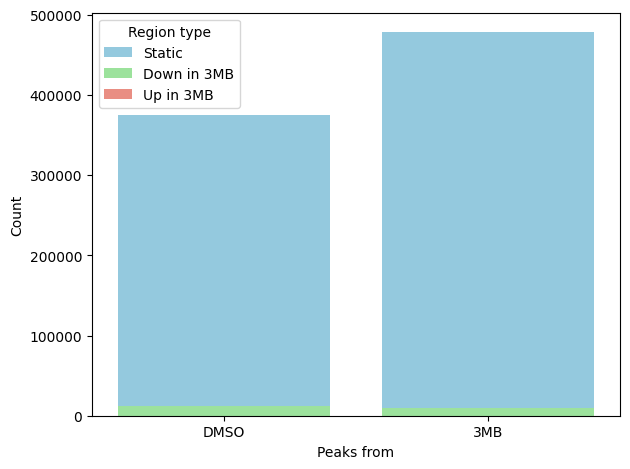

In [32]:
plot_data = pd.DataFrame({
    "Peaks from": ["DMSO"] * 3 + ["3MB"] * 3,
    "Region type": ["Static", "Down in 3MB", "Up in 3MB"] * 2,
    "Count": [
        dmso_peaks_categories["static"],
        dmso_peaks_categories["differential_down"],
        dmso_peaks_categories["differential_up"],
        threeMB_peaks_categories["static"],
        threeMB_peaks_categories["differential_down"],
        threeMB_peaks_categories["differential_up"]
    ]
})

display(plot_data)

sns.barplot(
    data=plot_data,
    x="Peaks from",
    y="Count",
    hue="Region type",
    estimator=sum,
    dodge=False,
    palette=["skyblue", "lightgreen", "salmon"]
)

# Add labels and title
plt.ylabel("Count")
plt.legend(title="Region type")
plt.tight_layout()

# Show plot
plt.show()

In [5]:
os.system("jupyter nbconvert peak_stats.ipynb --to html --output peak_stats.html")

[NbConvertApp] Converting notebook peak_stats.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 355490 bytes to peak_stats.html


0

## Create a bar plot of peaks per chromosome

Using all peaks, not just top 4000

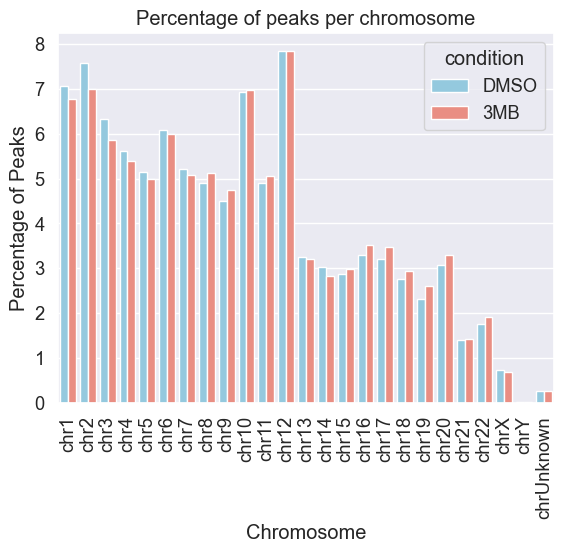

In [14]:
known_chrs = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
chr_plot_data = []

for chr in known_chrs:
    chr_peaks_dmso = peaks_dmso_all[peaks_dmso_all["chr"] == chr]
    chr_peaks_threeMB = peaks_threeMB_all[peaks_threeMB_all["chr"] == chr]
    
    chr_plot_data.append({"chr": chr, "count": len(chr_peaks_dmso), "condition": "DMSO"})
    chr_plot_data.append({"chr": chr, "count": len(chr_peaks_threeMB), "condition": "3MB"})

unknown_chr_peaks_dmso = peaks_dmso_all[~peaks_dmso_all["chr"].isin(known_chrs)]
unknown_chr_peaks_threeMB = peaks_threeMB_all[~peaks_threeMB_all["chr"].isin(known_chrs)]
chr_plot_data.append({"chr": "chrUnknown", "count": len(unknown_chr_peaks_dmso), "condition": "DMSO"})
chr_plot_data.append({"chr": "chrUnknown", "count": len(unknown_chr_peaks_threeMB), "condition": "3MB"})

chr_plot_data_df = pd.DataFrame(chr_plot_data)

chr_plot_data_df["perc"] = chr_plot_data_df["count"] / chr_plot_data_df.groupby("condition")["count"].transform("sum") * 100

sns.barplot(
    data=chr_plot_data_df,
    x="chr",
    y="perc",
    hue="condition",
    estimator=sum,
    dodge=True,
    palette=["skyblue", "salmon"],
)

plt.xlabel("Chromosome")
plt.ylabel("Percentage of Peaks")
plt.title("Percentage of peaks per chromosome")
plt.xticks(rotation=90)

plt.savefig("Output/peak_chr_plot.svg", format="svg")

## Use intervene to plot a heatmap of the replicate's peaks

Note: Had to update the intervene package to correctly import Iterable

In [ ]:
pipeline_output_peaks_folder = "../../bwa/merged_library/macs2/broad_peak"
intervene_input_peaks_folder = "Input/intervene"
intervene_output_folder = "Output"

bed_file_list = []

for condition in ["3MB", "DMSO"]:
    for rep in [1, 2, 3, 4]:
        pipeline_peaks_file = f"{pipeline_output_peaks_folder}/{condition}_REP{rep}.mLb.clN_peaks.bed"
        intervene_peaks_file = f"{intervene_input_peaks_folder}/{condition}_REP{rep}.bed"
        # run_command(f"cp {pipeline_peaks_file} {intervene_peaks_file}")
        bed_file_list.append(intervene_peaks_file)

run_command(f"intervene pairwise -i {" ".join(map(str, bed_file_list))} --type genomic --compute jaccard --htype tribar --output {intervene_output_folder}")

Running command: intervene pairwise -i Input/intervene/3MB_REP1.bed Input/intervene/3MB_REP2.bed Input/intervene/3MB_REP3.bed Input/intervene/3MB_REP4.bed Input/intervene/DMSO_REP1.bed Input/intervene/DMSO_REP2.bed Input/intervene/DMSO_REP3.bed Input/intervene/DMSO_REP4.bed --type genomic --compute jaccard --htype tribar

Performing a pairwise intersection analysis. Please wait...



/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/intervene/modules/pairwise/pairwise.py:464: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  matrix = pd.read_table(matrix_file,index_col=0, delim_whitespace=True)
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/intervene/modules/pairwise/pairwise.py:165: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(visible=False, which='major', axis='both', alpha=0.1)



You are done! Please check your results @ /Volumes/kueck/Pipeline/CellLines/ATAC/merged-230504_VL00320_62_AACNJL5M5-230426_VL00320_57_AACML2FM5/analysis/homer/Intervene_results. 
Thank you for using Intervene!

